In [8]:
import gtfs2nx as gx
import networkx as nx
import geopandas as gpd
import matplotlib.pyplot as plt

## Read a feed and filter it by a boundary

### Create the boundary

<Axes: >

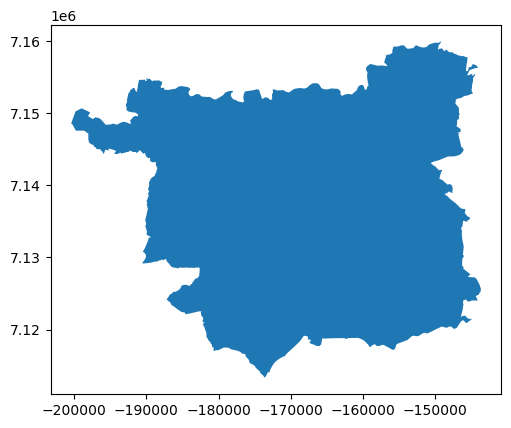

In [9]:
boundary = gpd.read_file('../data/study_area_boundary.geojson')
# edit crs
boundary = boundary.to_crs('EPSG:3857')
# convert to one border
boundary = boundary.unary_union

gpd.GeoSeries(boundary).plot()

### Read and filter the feed

In [10]:
path = '../data/study_area_gtfs_bus_f.zip'
G = gx.transit_graph(path, 
                     time_window=('06:00', '10:00'), 
                     boundary = boundary, 
                     crs = 'EPSG:3857',
                     walk_transfer_max_distance = 50
                    )

2024-05-26 10:51:54,044 | INFO | STEP 1/5 - Loading GTFS feed(s) ...
2024-05-26 10:51:55,015 | INFO | STEP 2/5 - Preprocessing GTFS feeds ...
2024-05-26 10:51:55,931 | INFO |            Filtering transit service between 06:00 and 10:00...


/home/hussein/miniconda3/envs/midpoint/lib/python3.12/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/home/hussein/miniconda3/envs/midpoint/lib/python3.12/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


2024-05-26 10:51:56,113 | INFO | Removed 41 trips with unrealistic travel speeds (>108km/h).
2024-05-26 10:51:56,118 | INFO | STEP 3/5 - Determining service frequency, transfer waiting & travel times...
2024-05-26 10:51:56,452 | INFO | {INDENT}Filtering by geographical boundary...
2024-05-26 10:51:58,721 | INFO | STEP 4/5 - Creating NetworkX graph...
2024-05-26 10:51:58,803 | INFO | STEP 5/5 - Adding edges for walk transfers between stops no more than 50 m apart (assuming walk speed of 4 km/h)...


In [11]:
# show first 5 edges
list(G.edges(data=True))[:50]

[('450010001@@30529', '450010001@@30529', {'weight': 0.0, 'mode': 'transit'}),
 ('450010001@@30529', '450012111@@30529', {'weight': 56.0, 'mode': 'transit'}),
 ('450012111@@30529',
  '450011480@@30529',
  {'weight': 182.33333333333334, 'mode': 'transit'}),
 ('450012111@@30529', '450012111@@30529', {'weight': 0.0, 'mode': 'transit'}),
 ('450010002@@30529',
  '450010001@@30529',
  {'weight': 107.66666666666667, 'mode': 'transit'}),
 ('450010002@@30529', '450010002@@30529', {'weight': 0.0, 'mode': 'transit'}),
 ('450010003@@30529', '450010002@@30529', {'weight': 61.0, 'mode': 'transit'}),
 ('450010003@@30529', '450010003@@30529', {'weight': 0.0, 'mode': 'transit'}),
 ('450010004@@30529',
  '450010003@@30529',
  {'weight': 55.333333333333336, 'mode': 'transit'}),
 ('450010004@@30529', '450010004@@30529', {'weight': 0.0, 'mode': 'transit'}),
 ('450010005@@12120', '450010005@@12120', {'weight': 0.0, 'mode': 'transit'}),
 ('450010005@@12120', '450014432@@12120', {'weight': 97.0, 'mode': 'tran

In [ ]:
# visualize service frequency of stops

gx.utils.plot_network(G, 'frequency')

### Edge structure

In [7]:
# Get a list of the first 50 edges
first_10_edges = list(G.edges(data=True))[:10]

# Iterate over the first 50 edges
for edge in first_10_edges:
    print(edge)

('450010001@@30529', '450010001@@30529', {'weight': 0.0, 'mode': 'transit'})
('450010001@@30529', '450012111@@30529', {'weight': 56.0, 'mode': 'transit'})
('450012111@@30529', '450011480@@30529', {'weight': 182.33333333333334, 'mode': 'transit'})
('450012111@@30529', '450012111@@30529', {'weight': 0.0, 'mode': 'transit'})
('450010002@@30529', '450010001@@30529', {'weight': 107.66666666666667, 'mode': 'transit'})
('450010002@@30529', '450010002@@30529', {'weight': 0.0, 'mode': 'transit'})
('450010003@@30529', '450010002@@30529', {'weight': 61.0, 'mode': 'transit'})
('450010003@@30529', '450010003@@30529', {'weight': 0.0, 'mode': 'transit'})
('450010004@@30529', '450010003@@30529', {'weight': 55.333333333333336, 'mode': 'transit'})
('450010004@@30529', '450010004@@30529', {'weight': 0.0, 'mode': 'transit'})


### Node structure

In [ ]:
# Get a list of the first 50 nodes
first_10_nodes = list(G.nodes(data=True))[:10]

# Iterate over the first 50 nodes
for node in first_10_nodes:
    print(node)
    

I'm asuming that each node will have multiple route ids. One for each unique route that passes through it. The code below shows this is not the case

In [ ]:
# Create a dictionary to store the route_id values for each node
node_route_ids = {}

# Iterate over all nodes
for node, data in G.nodes(data=True):
    # Get the route_id attribute
    route_id = data.get('route_id')

    # If the route_id exists, add it to the list for this node
    if route_id is not None:
        if node in node_route_ids:
            node_route_ids[node].append(route_id)
        else:
            node_route_ids[node] = [route_id]

# Print the nodes that have more than one route_id
for node, route_ids in node_route_ids.items():
    if len(route_ids) > 1:
        print(f'Node: {node}, route_ids: {route_ids}')

Do we have different nodes in the exact same location? YES

In [ ]:
# Create a dictionary to count the occurrences of each (x, y) pair
xy_counts = {}

# Iterate over all nodes
for node, data in G.nodes(data=True):
    # Get the x and y attributes
    x = data.get('x')
    y = data.get('y')

    # If both x and y exist, increment the count for this pair
    if x is not None and y is not None:
        xy = (x, y)
        if xy in xy_counts:
            xy_counts[xy] += 1
        else:
            xy_counts[xy] = 1

# Print the (x, y) pairs that occur more than once
for xy, count in xy_counts.items():
    if count > 1:
        print(f'(x, y): {xy}, count: {count}')

We should group the nodes in the same location. If we do that, we can identify the routes that traverse the same edges. Is this possible in networkx? We can't just modify the edges, as the travel_time (weight) is different depending on the bus route ...

The edge should have a dictionary with {route_id: weight}